# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<div class="alert alert-block alert-info">
<b>"Бета-Банк и история о том как удержать клиентов"</b> 
    
За основу у нас приняты данные о пользователях,
    
</div>

## Подготовка данных

<div class="alert alert-block alert-info">
<b></b> Импортируем основные библиотеки
</div>

In [1]:
# импорты сторонних библиотек
import numpy as np
import pandas as pd

# импорты из стандартной библиотеки
import warnings


# импорты модулей текущего проекта
# длина строки до 78 символов
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pylab as plt
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split)

#настройки
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<b></b> Считаем файл и посмотрим, что у нас со значениеями в столбцах.
</div>

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<div class="alert alert-block alert-info">
<b></b> Сталкиваемся с первой проблемой, в столбце Tenure отсутствует 909 значений от общей выборки это почти 10%. Через метод query ознакомимся, попробуем найти особенности данных пропусков. Также подсчитаем какое количество пользователей верой и правдой пользуется услугами банка.
</div>

In [4]:
df.query('Tenure.isnull()', engine='python').sort_values(by='Tenure')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [5]:
df.query('IsActiveMember == 1 and Tenure.isnull()').sort_values(by='RowNumber')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
123,124,15760085,Calabresi,684,Germany,Female,48,NaN,126384.42,1,1,1,198129.36,0
180,181,15716334,Rozier,850,Spain,Female,45,NaN,122311.21,1,1,1,19482.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,9890,15711489,Azikiwe,760,Spain,Female,32,NaN,0.00,1,1,1,114565.35,0
9901,9902,15802909,Hu,706,Germany,Female,56,NaN,139603.22,1,1,1,86383.61,0
9923,9924,15786789,Ni,725,France,Female,29,NaN,0.00,2,1,1,190776.83,0
9925,9926,15605672,Yuan,694,France,Female,38,NaN,195926.39,1,1,1,85522.84,0


In [6]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [7]:
df['Tenure'].median()

5.0

<div class="alert alert-block alert-info">
<b></b> Первичный анализ, не показал какой-либо явной связи пропусков с другими данными. Есть предположение что все пропуски связаны с какой-либо ошибкой в данных. Потому-что при изучении других столбцов, видно, что часть этих клиентов активные пользователи банка, многие испольуют по 2-3 продукта от банка. Другое предположение, что это могут быть пользователи, которые только хотят стать клиентами банка. Т.е банковские работники, вбили все данные о них будущих их клиентах, но те в свою очередь ещё не получили свои банковские карты/кредиты и т.д. Но я всё же скланяюсь к своему первому предположению, оно более реалистичное. Можно былоб попробовать заполнить данные медианным значением, но тогда число клиентов с банковским стажем 5 лет вдвое возрастёт, что может отразиться на искажении данных. В выборке у нас 10000 значений, а это достаточно большая выборка. Принимаю решение удалить пропущеные значения.
</div>

<div class="alert alert-block alert-info">
<b></b> На гистограмме видно, чтоу более 3000 пользователей присутствует нулевой баланс счёта. В целом такая ситуация возможна, они могут пользоваться другими услугами банка и не платить их картой, не пользоваться счётом. 

</div>

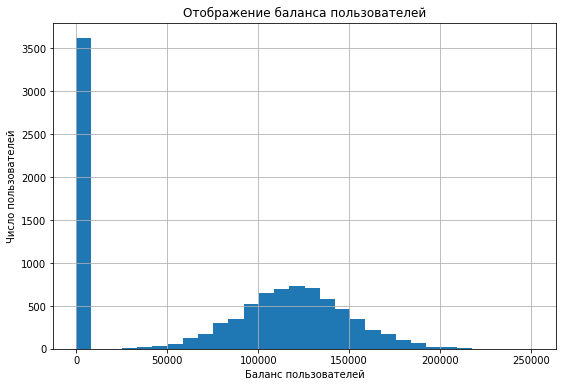

In [12]:
df['Balance'].hist(bins=30, figsize=(9, 6)).set_title('Отображение баланса пользователей')
plt.xlabel("Баланс пользователей")
plt.ylabel("Число пользователей")
plt.show()

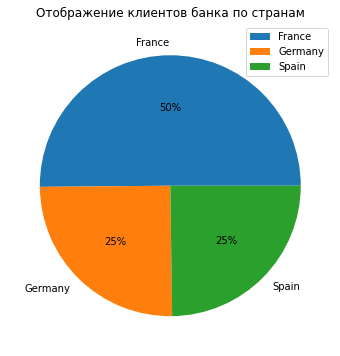

In [13]:
Geogr_piv_table = df.pivot_table(index='Geography', values='RowNumber', aggfunc=['count'])
Geogr_piv_table.columns=['Count_of_users']
Geogr_piv_table.plot(kind='pie', y='Count_of_users', figsize=(9, 6), autopct='%1.0f%%').set_title('Отображение клиентов банка по странам')
plt.ylabel("")
plt.show()

<div class="alert alert-block alert-info">
<b></b> На диаграмме видно, что большинство клиентов банка приходится на Францию, остальные доли равнозначно распределены между Германией и Испанией. Из этой диаграммы можно сделать одно важное заключение о том, что вся зарплата клиентов будет представлена в Евро. И нам не придётся ещё выполнять какие-либо конвертации.
</div>

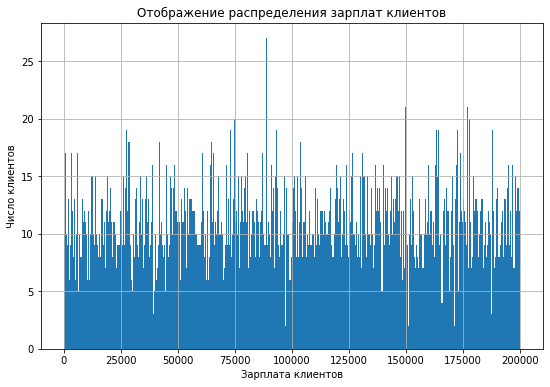

In [14]:
df['EstimatedSalary'].sort_values(ascending=False).hist(bins=900, figsize=(9, 6)).set_title('Отображение распределения зарплат клиентов')
plt.xlabel("Зарплата клиентов")
plt.ylabel("Число клиентов")
plt.show()

<div class="alert alert-block alert-info">
<b></b> На гистограмме видно, что уровни зарплат находятся в очень широком диапазоне. Имеются клиенты и нулевым зарботком, а также клиенты с заработком по 200тыс.евро. В целом такая ситуация ничем не примечательная, все зарабатывают в меру своих возможностей.
</div>

<div class="alert alert-block alert-info">
<b>Промежуточный вывод по первом разделу</b> 
    
1) Пропущенные значения заменим методов KNNTenure. Это выполним мы на следующем шаге.

2) Увидели, что треть пользователей нулевой баланс счёта. В текущих реалиях это возможно. Люди начинают пользоваться услугами карт из-за каких-либо разных причин (бесплатное обслуживание, приведи друга и получи деньгу и т.д.), выполнив условия просто перестают пользоваться счётом и всё. Раз за обслуживание платить не надо, то и закрывать счёт многие не хотят, вдруг произойдёт снова какая-то выгодная акция.

3) Из диаграммы, которая отображает клиентов банка по странам, видно, что 50% клиентов приходится на Францию, а остальные по 25% на Германия и Испанию. Также сделали важное заключение, что все пользователи получают зарплату в Евро.

4) Из гистограммы распределния зарплат клиентов банка поняли, что уровень зарплат находится в широком диапазоне, есть те кто не зарабатывает совсем, а есть те, кто делают хорошие деньги, и всё равно остаются верны данному банку.
    
</div>

<div class="alert alert-block alert-info">
<b>ВАЖНОЕ !!! ИЗМЕНИЯ ПОСЛЕ ПЕРВОЙ ПРОВЕРКИ.
 
Я понял, что удалять придётся слишком, для вторых и последующих пунктов, поэтому решил перенести весь переделанный проект в конец. Поэтому, Марат, что бы увидеть правки, листайте в самый низ. Наверное это не сильно грамотно, но теперь, чтоб исправить этот и не запутаться самому, я решил отделить его. Слишком разительные отличия просто.
 </b>
</div>

## Исследование задачи

<div class="alert alert-block alert-info">
<b>ПРОДОЛЖЕНИЕ ПРОЕКТА СО ВТОРОГО ПУНКТА </b>


In [39]:
df = pd.read_csv('/datasets/Churn.csv')
df_copy = df.copy()

<div class="alert alert-block alert-info">
<b></b> Определяем целевой столбец и рабочие.
</div>


In [40]:
df_copy = df_copy.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [41]:
target = df_copy['Exited']
features = df_copy.drop('Exited', axis=1)

<div class="alert alert-block alert-info">
<b></b> Задаём значение всевдослучайности.
</div>

In [42]:
state=12345

<div class="alert alert-block alert-info">
<b></b> Разделяем выборки
</div>

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, 
                                                                                random_state=state
                                                                               )

features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, 
                                                                                test_size=0.5, random_state=state
                                                                               )

<div class="alert alert-block alert-info">
<b></b> Распишем функцию для увеличения выборки. Но для начала посмотрим, на сколько отличается выборка целевого признака, отношение 0 к 1.
</div>

In [44]:
target_train.value_counts()

0    4804
1    1196
Name: Exited, dtype: int64

In [45]:
rat = len(target_train.loc[target_train==0])/len(target_train.loc[target_train==1])
rat

4.016722408026756

<div class="alert alert-block alert-info">
<b></b> Всё таки значение больше к четырём, поэтому увеличим выборку в 4 раза. Установим значение repeat=4.
</div>

In [46]:
def upsample(features, target, repeat=4):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    
    features_upsampled=pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled=pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=state)
    
    return features_upsampled, target_upsampled

In [47]:
features_upsampled, target_upsampled = upsample(features_train, target_train)

<div class="alert alert-block alert-info">
<b></b> На гистограмме проверим, что у нас всё получилось и выборки сравнялись.
</div>

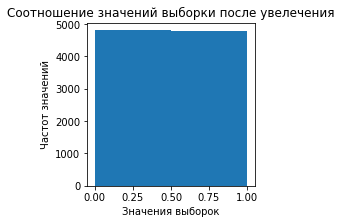

In [48]:
target_upsampled.plot(kind ='hist', bins=2, figsize=(3,3))
plt.title('Соотношение значений выборки после увелечения')
plt.xlabel('Значения выборок')
plt.ylabel('Частот значений')
plt.show()

<div class="alert alert-block alert-info">
<b></b> Распишем функции для уменьшения выборки. Раз в прошлой функции, мы увеличивали выборку в 4 раза, здесь нам надое её уменьшить в 4 раза, чтобы привести к равному диапазону. Установим значение frac=0.25.
</div>

In [49]:
def downsample(features, target, fraction=0.25):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [50]:
features_downsampled, target_downsampled = downsample(features_train, target_train)

<div class="alert alert-block alert-info">
<b></b> На гистограмме проверим, что у нас всё получилось и выборки сравнялись.
</div>

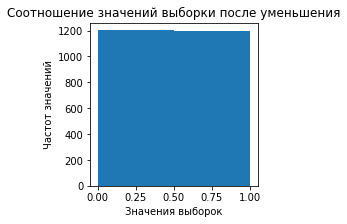

In [51]:
target_downsampled.plot(kind ='hist', bins=2, figsize=(3,3))
plt.title('Соотношение значений выборки после уменьшения')
plt.xlabel('Значения выборок')
plt.ylabel('Частот значений')
plt.show()

<div class="alert alert-block alert-info">
<b></b> Разделяем тренировочную выборку на категориальные и численные признаки
</div>

In [52]:
obj_features = features_train.select_dtypes(include='object').columns.to_list()

print(obj_features)

['Geography', 'Gender']


In [53]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

print(num_features)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


<div class="alert alert-block alert-info">
<b></b> Для категориальнный признаков используем метод OHE,а для численных Scaler
</div>

In [54]:
encoder_ohe = OneHotEncoder(drop='first', sparse = False)

encoder_ohe.fit(features_train[obj_features])
encoder_ohe.fit(features_valid[obj_features])
encoder_ohe.fit(features_test[obj_features])
encoder_ohe.fit(features_upsampled[obj_features])
encoder_ohe.fit(features_downsampled[obj_features])


features_train[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_train[obj_features])
features_train = features_train.drop(obj_features, axis=1)

features_valid[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_valid[obj_features])
features_valid = features_valid.drop(obj_features, axis=1)

features_test[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_test[obj_features])
features_test = features_test.drop(obj_features, axis=1)

features_upsampled[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_upsampled[obj_features])
features_upsampled = features_upsampled.drop(obj_features, axis=1)

features_downsampled[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_downsampled[obj_features])
features_downsampled = features_downsampled.drop(obj_features, axis=1)


scaler = StandardScaler()
scaler.fit(features_train[num_features]) 
features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])
features_upsampled[num_features] = scaler.transform(features_upsampled[num_features])
features_downsampled[num_features] = scaler.transform(features_downsampled[num_features])

<div class="alert alert-block alert-info">
<b></b> Смотим что всё получилось
</div>

In [55]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
7479,-0.830326,-0.366305,1.090238,1.208467,-0.936108,0.647647,-0.995012,-0.215327,0.0,1.0,1.0
3411,0.662367,-0.179462,1.090238,0.582387,-0.936108,-1.544051,-0.995012,-0.361139,0.0,0.0,0.0
6027,2.103231,0.474487,-0.629056,1.005122,0.772118,-1.544051,1.005013,1.470525,1.0,0.0,1.0
1247,-1.400452,-1.393940,0.402520,-1.235001,0.772118,0.647647,-0.995012,-1.096096,0.0,0.0,1.0
3716,0.185535,-1.113676,-0.972915,1.117489,-0.936108,-1.544051,-0.995012,1.491636,1.0,0.0,0.0


<div class="alert alert-block alert-info">
<b></b> Заполним пропуски методом ближайших соседей (KNNImputer)
</div>

In [56]:
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')

features_train = pd.DataFrame(knn_imputer.fit_transform(features_train), columns = features_train.columns)
features_valid = pd.DataFrame(knn_imputer.fit_transform(features_valid), columns = features_valid.columns)
features_test = pd.DataFrame(knn_imputer.fit_transform(features_test), columns = features_test.columns)
features_upsampled = pd.DataFrame(knn_imputer.fit_transform(features_upsampled), columns = features_upsampled.columns)
features_downsampled = pd.DataFrame(knn_imputer.fit_transform(features_downsampled), columns = features_downsampled.columns)

features_train.Tenure.isna().sum(), features_train.shape

(0, (6000, 11))

<div class="alert alert-block alert-info">
<b></b> Данным шагом я хотел обратно преобразовать датафрейм, чтоб взглянуть как заполнился столбец Tenure, но ошибка которая там вызалит, я понимаю что проблема там в матричном перемножении, как пишет ошибка. Но как решить её в данном методе, я ответов в интернете и на других источниках не нашёл. Поверю в святого духа, что данные заполнились и получилось что-то похожее на нормальное распределение. Ну и построим график их того, что имеется. Нормальным распределением конечно не сильно пахнет, но спишем это, на особенность масштабированния данных.
</div>

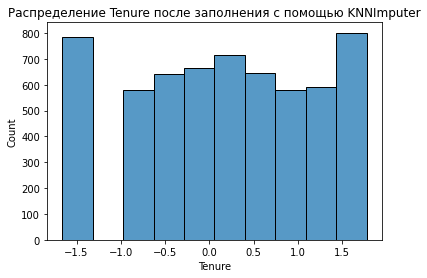

In [57]:
sns.histplot(features_train['Tenure'], bins = 10)
plt.title('Распределение Tenure после заполнения с помощью KNNImputer');

<div class="alert alert-block alert-info">
<b></b> Теперь можем перейти к шагу обучения моделей. Выборки у нас все готовы, данные отмасштабированы по всем признакам.
</div>

## Исследование задачи

<div class="alert alert-block alert-info">
<b></b> Введём функцию помощника для предсказания данных.
</div>

In [ ]:
def train_and_predict(model,  features_train, target_train, features_valid):  
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    cros_val_result = 
    result = f1_score(target_valid, predicted_valid) 

    return result

<div class="alert alert-block alert-info">
<b>Логистическая регрессия</b> 
</div>

In [59]:
model = LogisticRegression(solver='liblinear', random_state=state)
print(f'Лучшее значение F1-меры:{train_and_predict(model, features_train, target_train, features_valid)}')

Лучшее значение F1-меры:0.33052276559865096


<div class="alert alert-block alert-info">
<b>Случайный лес</b> 
</div>

In [60]:
%%time

best_res = 0
best_depth = 0
best_est = 0

count_F1 = []
count_depth = []
count_est = []

for est in range(10, 250, 10):
    for depth in range (1, 16, 1):
        model_RFC = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=state)
        result = train_and_predict(model_RFC, features_train, target_train, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
            best_est = est
        count_F1.append(result)
        count_depth.append(depth)
        count_est.append(est)   

print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}, оптимальное разветвление:{best_est}')


Лучшее значение F1-меры:0.595166163141994, оптимальная глубина:15, оптимальное разветвление:60
CPU times: user 3min 48s, sys: 1.05 s, total: 3min 49s
Wall time: 3min 49s


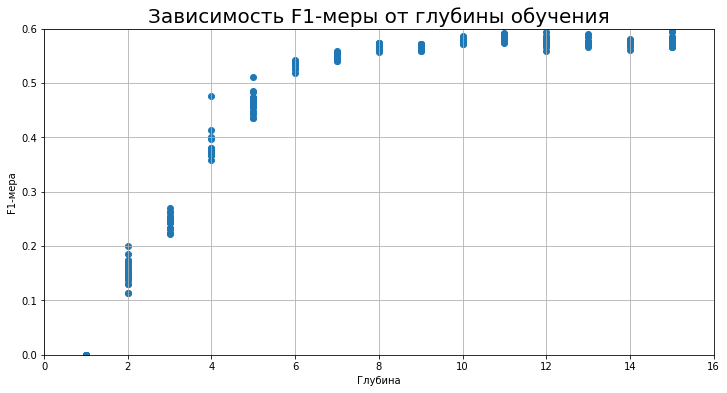

In [61]:
plt.figure(figsize=(12, 6));
plt.scatter(count_depth, count_F1)
plt.axis([0,16,0,0.6])
plt.title('Зависимость F1-меры от глубины обучения', fontsize=20)
plt.xlabel('Глубина', color='black')
plt.ylabel('F1-мера',color='black')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b></b> Видно, что при увеличении глубины значения F1 меры увеличивались (до 13), а затем пошло на спад. Видимо там настал момент переобучения.
</div>

<div class="alert alert-block alert-info">
<b>Дерево решений</b> 
</div>

In [62]:
%%time

best_res = 0
best_depth = 0

for depth in range (1, 5, 1):
        model_DTC = DecisionTreeClassifier(max_depth=depth, random_state=state)
        result = train_and_predict(model_DTC, features_train, target_train, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
    
            
print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}')

Лучшее значение F1-меры:0.5528700906344411, оптимальная глубина:4
CPU times: user 44.7 ms, sys: 9 µs, total: 44.7 ms
Wall time: 43.2 ms


<div class="alert alert-block alert-info">
<b>Промежуточный вывод по второму разделу</b> 
    
1) Даже с учётом небаланса классов, наилучший результат показала модель "Случайного леса" со следующим гиперпараметрами и значением F1-меры: F1-мера:0.595, оптимальная глубина:15, оптимальное разветвление:60. Время обучения заняло около 3ёх минут (3 мин. 15 сек), в сравнении с другими моделями заметно дольше.
    
2) Наихудший результат показала модель логистической регрессии со значением F1-меры:0.33.
    
3) А вот модель "Решающего дерева" почти приблизилась к наилучшему значению модели "Случайного леса" и значениеF1-меры составило : 0.552, при оптимальной глубине:4
    
В целом результаты не такие страшные, на последующих этапах мы уравняем классы несколькими способами и посмотрим как это отразится на значение F1-меры.
    
</div>

## Борьба с дизбалансом

### Взвешвание классов

<div class="alert alert-block alert-info">
<b>Логистическая регрессия</b> 
</div>

In [63]:
model = LogisticRegression(solver='liblinear', random_state=state, class_weight='balanced')
print(f'Лучшее значение F1-меры:{train_and_predict(model, features_train, target_train, features_valid)}')

Лучшее значение F1-меры:0.4888507718696398


<div class="alert alert-block alert-info">
<b>Случайный лес</b> 
</div>

In [64]:
%%time

best_res = 0
best_depth = 0
best_est = 0

count_F1 = []
count_depth = []
count_est = []

for est in range(10, 250, 10):
    for depth in range (1, 16, 1):
        model_RFC = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=state, class_weight='balanced')
        result = train_and_predict(model_RFC, features_train, target_train, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
            best_est = est
        count_F1.append(result)
        count_depth.append(depth)
        count_est.append(est)

print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}, оптимальное разветвление:{best_est}')

Лучшее значение F1-меры:0.6367816091954022, оптимальная глубина:9, оптимальное разветвление:160
CPU times: user 3min 38s, sys: 743 ms, total: 3min 39s
Wall time: 3min 39s


<div class="alert alert-block alert-info">
<b>Дерево решений</b> 
</div>

In [65]:
%%time

best_res = 0
best_depth = 0

for depth in range (1, 5, 1):
        model_DTC = DecisionTreeClassifier(max_depth=depth, random_state=state, class_weight='balanced')
        result = train_and_predict(model_DTC, features_train, target_train, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
    
            
print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}')

Лучшее значение F1-меры:0.541015625, оптимальная глубина:2
CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 60 ms


<div class="alert alert-block alert-info">
<b>Промежуточный вывод по методу "Взвешивание классов"</b> 
    
1) Наилучший результат показала модель "Случайного леса" со следующим гиперпараметрами и значением F1-меры: F1-мера:0.636, оптимальная глубина:9, оптимальное разветвление:160. Время обучения заняло около 3ёх минут. 
    
2) Наихудший результат показала модель логистической регрессии со значением F1-меры:0.488. Но значение после балансировки классов, заметно возросло. Положительная тенденция приятна.
    
3) А вот модель "Решающего дерева" также добавила пару пунктов в улучшение собственного качества и значениеF1-меры составило : 0.541, при оптимальной глубине:2
    
Можно сказать, что балансировка классов, заметно помогла всем моделям преуспеть в увеличении значения F1-меры.
    
</div>

### Увеличение выборки

<div class="alert alert-block alert-info">
<b>Логистическая регрессия</b> 
</div>

In [66]:
model = LogisticRegression(solver='liblinear', random_state=state)
print(f'Лучшее значение F1-меры:{train_and_predict(model, features_upsampled, target_upsampled, features_valid)}')

Лучшее значение F1-меры:0.4892703862660944


<div class="alert alert-block alert-info">
<b>Случайный лес</b> 
</div>

In [67]:
%%time

best_res = 0
best_depth = 0
best_est = 0

count_F1 = []
count_depth = []
count_est = []

for est in range(10, 250, 10):
    for depth in range (1, 16, 1):
        model_RFC = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=state)
        result = train_and_predict(model_RFC, features_upsampled, target_upsampled, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
            best_est = est
            count_F1.append(result)
            count_depth.append(depth)
            count_est.append(est)

print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}, оптимальное разветвление:{best_est}')

Лучшее значение F1-меры:0.6300518134715026, оптимальная глубина:8, оптимальное разветвление:30
CPU times: user 5min 3s, sys: 483 ms, total: 5min 3s
Wall time: 5min 4s


<div class="alert alert-block alert-info">
<b>Дерево решений</b> 
</div>

In [68]:
%%time

best_res = 0
best_depth = 0

for depth in range (1, 5, 1):
        model_DTC = DecisionTreeClassifier(max_depth=depth, random_state=state)
        result = train_and_predict(model_DTC, features_upsampled, target_upsampled, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
    
            
print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}')

Лучшее значение F1-меры:0.541015625, оптимальная глубина:2
CPU times: user 53.4 ms, sys: 8 µs, total: 53.5 ms
Wall time: 59.1 ms


<div class="alert alert-block alert-info">
<b>Промежуточный вывод по методу "Увеличение выборки"</b> 
    
1) Наилучший результат показала модель "Случайного леса" со следующим гиперпараметрами и значением F1-меры: F1-мера:0.63, оптимальная глубина:8, оптимальное разветвление:30. Время обучения заняло около 3ёх минут. 
    
2) Наихудший результат показала модель логистической регрессии со значением F1-меры:0.48. Значение стало чуть меньше, в отличии от взвешивания классов.
    
3) А вот модель "Решающего дерева" также потеряли пару пунктов и значениеF1-меры составило : 0.541, при оптимальной глубине:4
    
Можно сказать, что увеличение целевых параметров, слабо позволяет приблизиться к максимальному значению F1-меры.
    
</div>

### Уменьшение выборки

<div class="alert alert-block alert-info">
<b>Логистическая регрессия</b> 
</div>

In [69]:
model = LogisticRegression(solver='liblinear', random_state=state)
print(f'Лучшее значение F1-меры:{train_and_predict(model, features_downsampled, target_downsampled, features_valid)}')

Лучшее значение F1-меры:0.48275862068965514


<div class="alert alert-block alert-info">
<b>Случайный лес</b> 
</div>

In [70]:
%%time

best_res = 0
best_depth = 0
best_est = 0

count_F1 = []
count_depth = []
count_est = []

for est in range(10, 250, 10):
    for depth in range (1, 16, 1):
        model_RFC = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=state)
        result = train_and_predict(model_RFC, features_downsampled, target_downsampled, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
            best_est = est
            count_F1.append(result)
            count_depth.append(depth)
            count_est.append(est)

print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}, оптимальное разветвление:{best_est}')

Лучшее значение F1-меры:0.6104417670682731, оптимальная глубина:4, оптимальное разветвление:10
CPU times: user 1min 59s, sys: 476 ms, total: 2min
Wall time: 2min


<div class="alert alert-block alert-info">
<b>Дерево решений</b> 
</div>

In [71]:
%%time

best_res = 0
best_depth = 0

for depth in range (1, 5, 1):
        model_DTC = DecisionTreeClassifier(max_depth=depth, random_state=state)
        result = train_and_predict(model_DTC, features_downsampled, target_downsampled, features_valid)
        if result > best_res:
            best_res = result
            best_depth = depth
    
            
print(f'Лучшее значение F1-меры:{best_res}, оптимальная глубина:{best_depth}')

Лучшее значение F1-меры:0.5555555555555556, оптимальная глубина:3
CPU times: user 28.1 ms, sys: 0 ns, total: 28.1 ms
Wall time: 38 ms


<div class="alert alert-block alert-info">
<b>Промежуточный вывод по методу "Уменьшение выборки"</b> 
    
1) Наилучший результат показала модель "Случайного леса" со следующим гиперпараметрами и значением F1-меры: F1-мера:0.561, оптимальная глубина:4, оптимальное разветвление:10. Время обучения заняло около 2ух минут. 
    
2) Наихудший результат показала модель логистической регрессии со значением F1-меры:0.482. Значение стало ещё на пару тысячных  меньше, в отличии от увелечения классов.
    
3) А вот модель "Решающего дерева" также добавило пару пунктов и значениеF1-меры составило : 0.555, при оптимальной глубине:3
    
Можно сказать, что уменьшение целевых параметров, также не позволяет приблизиться к максимальному значению F1-меры.
    
</div>

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ СТУДЕНТА V2</b>
    
-Парадокс есть, но всё же, хоть и называется логистическая регрессия,но она выполняет задачи классификации.
    
-Если правильно понимаю, логистическая регрессия плохо влияет на классификацию нелинейных разделимых наборов данных. А также основным ограничением логистической регрессии является предположение о линейности между зависимой переменной и независимыми переменными. Думаю всё же у нас есть столбцы с нелинейными данными, такие как - зарплата клиентов банка, сколькими продуктами банка он пользуется, кредитная история. (Моё предположение).
    
-Есть предположение, если правильно перевод статьи понял, что при недостатке целевого признака относительно всех признаков, логистическая регрессия может переобучаться, что и приводит к снижению точности модели. Когда мы организоваи баланс классов или увеличили выборку целевого признака. Когда выборку мы уменьшаньшили, у нас наоборот, остаьная выборка тоже значительно уменьшилась, и целевой признак мы там тоже пытаись выставить в уровне. Наверно в связи с этим и получилось увеличение точности модели.
</div>

## Тестирование модели

<div class="alert alert-block alert-info">
Протестируем модель, которая показала самые оптимальные параметры, а именно: модель = "Случайный лес", оптимальная глубина = 9, оптимальное разветвление = 120, метод повышения точности = "Взвешивание классов". 

In [72]:
model = RandomForestClassifier(random_state=state, max_depth=9, n_estimators=120, class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print(f'Значение F1-меры на валидационной выборке: {f1_score(target_valid, predicted_valid)}')

predicted_test = model.predict(features_test)
print(f'Значение F1-меры на тестовой выборке: {f1_score(target_test, predicted_test)}')

Значение F1-меры на валидационной выборке: 0.6267281105990784
Значение F1-меры на тестовой выборке: 0.6174801362088537


In [73]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC равняется: {auc_roc}')

AUC-ROC равняется: 0.8556911183832469


<div class="alert alert-block alert-info">
Дополнительно отобразим ROC-кривую. 

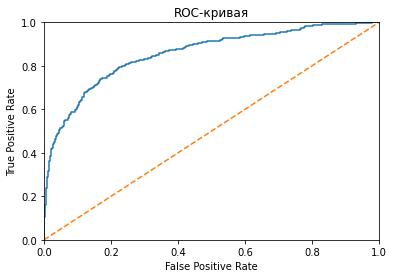

In [74]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<div class="alert alert-block alert-info">
<b>Итоговый вывод по проекту</b> 
    
1) Наилучшей обученной моделью стала модель "Случайного леса" со следующими гиперпараметрами: оптимальная глубина = 9, оптимальное разветвление = 120, метод повышения точности = "Взвешивание классов". Значение F меры на обученной модели составила - 0.612.
    
2) Тестовое значение F1-меры на основе оптимальных гиперпараметров составило: 0.671. В целом результат получился лучше чем ожидаемый. От нас требовалось добиться точности выше 0.59, и мы с лихвой перевалили за это значение.

3) Значение AUC-ROC (площадь от нашей кривой - синияя линия, до штриховой линии(случайные предсказанаия модели)- оранжевая) составило 0.852. Значение довольно высокое. Значит доля вернопредсказаных объектов к общему числу объектов больше относительно ложных срабатываний.
    
Все поставленные задачи были выполненые. 
Теперь, после ваших правок, прям гораздо глубже закопался в некоторых вопросах, что за чем идёт. На практике понял, чем отличается масштабирование классов, что такое порядковое и прямое кодирование. Что у этих параметров присутствуют более изящные пути решения. Понял, что пропуски иногда следует заменять на другие значения, прибегая к машинному обучения для дальнейшего заполнения пропусков. Потратил много времени, перерыл много материала. Но сейчас понимаю суть описанных выше подходов. Благодраю за комментарии. Думаю этот вариант устроит больше. Да, я ещё не все ваши советы использовал на практике, в связи со временем. Но в дальнейшем их учту. Но на большинсто вопросов вроде бы ответил.
    

</div>